In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q "/content/drive/MyDrive/cardamagecnn.zip" -d /content/datasets


In [5]:
import os
print(os.listdir("/content/datasets"))

['cardamagecnn']


In [6]:
dataset_path = "/content/datasets/cardamagecnn"

In [10]:
#I am doing data augmentation like jitter, flip horizontal flip,rotation,bringing same size
image_transforms = transforms.Compose([
     transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#mean std from imagenet for transfer learning from 14 million i may do later if accuracy is not great as only 2300 images

In [11]:
##Loading data

dataset = datasets.ImageFolder(root=dataset_path,transform=image_transforms )


In [12]:
print("Classes:", dataset.classes)
print("Total images:", len(dataset))

Classes: ['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']
Total images: 2300


In [14]:
dataset.classes
#6 classes altogether

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [15]:
num_classes = len(dataset.classes)
num_classes

6

In [17]:
2300*0.75

1725.0

In [16]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [18]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [19]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [20]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [21]:
images[1].shape

torch.Size([3, 224, 224])

In [23]:
labels[1] #type of  breakage

tensor(4)

In [24]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

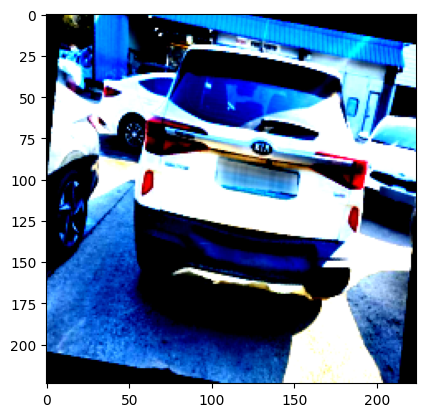

In [25]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

Model 1: **CNN**

In [27]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),image reduced to half
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(), #flattening before going in fcn
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes) ##did not hard code classes what if tommorow numclasses change
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [35]:
def train_model(model, criterion, optimizer, epochs=5):      #training model
    start = time.time() # i wanted to see the time it took

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device) #gpu t4

            # i Zeroed the parameter gradients for batch
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (batch_num+1) % 10 == 0: ##every 10th batch batch print
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")

            running_loss += loss.item() * images.size(0)#--batch size 32

        epoch_loss = running_loss / len(train_loader.dataset) ###geting avy loss and len is 1725
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()#to python element
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")

    end = time.time()
    print(f"Execution time: {end - start} seconds")

    return all_labels, all_predictions

In [34]:
#torch.max(torch.tensor([[1,2,9,3,4,5]]),1)#

torch.return_types.max(
values=tensor([9]),
indices=tensor([2]))

In [36]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=3)

Batch: 10, Epoch: 1, Loss: 1.80
Batch: 20, Epoch: 1, Loss: 1.70
Batch: 30, Epoch: 1, Loss: 1.55
Batch: 40, Epoch: 1, Loss: 1.46
Batch: 50, Epoch: 1, Loss: 1.56
Epoch [1/3], Avg Loss: 1.8248
*** Validation Accuracy: 41.04% ***
Batch: 10, Epoch: 2, Loss: 1.20
Batch: 20, Epoch: 2, Loss: 1.51
Batch: 30, Epoch: 2, Loss: 1.41
Batch: 40, Epoch: 2, Loss: 1.46
Batch: 50, Epoch: 2, Loss: 1.50
Epoch [2/3], Avg Loss: 1.4260
*** Validation Accuracy: 47.48% ***
Batch: 10, Epoch: 3, Loss: 1.41
Batch: 20, Epoch: 3, Loss: 1.18
Batch: 30, Epoch: 3, Loss: 1.16
Batch: 40, Epoch: 3, Loss: 1.44
Batch: 50, Epoch: 3, Loss: 1.12
Epoch [3/3], Avg Loss: 1.2722
*** Validation Accuracy: 52.00% ***
Execution time: 194.37559866905212 seconds


In [ ]:
#An insight from above loss may have decreased but bad validation performance might be over fitting only like 52 percent

Model 2: CNN with Regularization **l2** ,dropout,batch normalization

In [37]:
class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224)
            nn.BatchNorm2d(16),#added batch norm on ouput channels on previous layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),#added dropout
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [38]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)#l2 regularization added

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=5)

#let me run for 5 epochs

Batch: 10, Epoch: 1, Loss: 20.42
Batch: 20, Epoch: 1, Loss: 7.54
Batch: 30, Epoch: 1, Loss: 2.35
Batch: 40, Epoch: 1, Loss: 1.68
Batch: 50, Epoch: 1, Loss: 1.34
Epoch [1/5], Avg Loss: 8.2653
*** Validation Accuracy: 47.13% ***
Batch: 10, Epoch: 2, Loss: 1.36
Batch: 20, Epoch: 2, Loss: 1.26
Batch: 30, Epoch: 2, Loss: 1.36
Batch: 40, Epoch: 2, Loss: 1.32
Batch: 50, Epoch: 2, Loss: 1.26
Epoch [2/5], Avg Loss: 1.3382
*** Validation Accuracy: 51.65% ***
Batch: 10, Epoch: 3, Loss: 1.06
Batch: 20, Epoch: 3, Loss: 1.43
Batch: 30, Epoch: 3, Loss: 1.31
Batch: 40, Epoch: 3, Loss: 1.10
Batch: 50, Epoch: 3, Loss: 1.26
Epoch [3/5], Avg Loss: 1.2536
*** Validation Accuracy: 51.83% ***
Batch: 10, Epoch: 4, Loss: 1.21
Batch: 20, Epoch: 4, Loss: 1.34
Batch: 30, Epoch: 4, Loss: 1.43
Batch: 40, Epoch: 4, Loss: 1.18
Batch: 50, Epoch: 4, Loss: 1.08
Epoch [4/5], Avg Loss: 1.1921
*** Validation Accuracy: 53.39% ***
Batch: 10, Epoch: 5, Loss: 0.96
Batch: 20, Epoch: 5, Loss: 1.03
Batch: 30, Epoch: 5, Loss: 1.06

Model 4: Transfer Learning with ResNet ,has residual connection a very good winner in imagenet competition

In [41]:
model = models.resnet50(weights='DEFAULT')
print(model.fc.in_features)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


2048


In [43]:

# Loading  the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freezing all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreezing layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes) ##how many features after last convolution pooling
        )

    def forward(self, x):
        x = self.model(x)
        return x







In [44]:
model =CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 0.99
Batch: 20, Epoch: 1, Loss: 0.59
Batch: 30, Epoch: 1, Loss: 0.73
Batch: 40, Epoch: 1, Loss: 0.68
Batch: 50, Epoch: 1, Loss: 0.85
Epoch [1/5], Avg Loss: 0.8979
*** Validation Accuracy: 74.61% ***
Batch: 10, Epoch: 2, Loss: 0.33
Batch: 20, Epoch: 2, Loss: 0.34
Batch: 30, Epoch: 2, Loss: 0.60
Batch: 40, Epoch: 2, Loss: 0.51
Batch: 50, Epoch: 2, Loss: 0.42
Epoch [2/5], Avg Loss: 0.4570
*** Validation Accuracy: 74.61% ***
Batch: 10, Epoch: 3, Loss: 0.38
Batch: 20, Epoch: 3, Loss: 0.44
Batch: 30, Epoch: 3, Loss: 0.59
Batch: 40, Epoch: 3, Loss: 0.29
Batch: 50, Epoch: 3, Loss: 0.33
Epoch [3/5], Avg Loss: 0.3533
*** Validation Accuracy: 77.57% ***
Batch: 10, Epoch: 4, Loss: 0.10
Batch: 20, Epoch: 4, Loss: 0.05
Batch: 30, Epoch: 4, Loss: 0.17
Batch: 40, Epoch: 4, Loss: 0.23
Batch: 50, Epoch: 4, Loss: 0.31
Epoch [4/5], Avg Loss: 0.2117
*** Validation Accuracy: 78.61% ***
Batch: 10, Epoch: 5, Loss: 0.05
Batch: 20, Epoch: 5, Loss: 0.15
Batch: 30, Epoch: 5, Loss: 0.17


# Got **81** percent accuracy

In [46]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.92      0.84       116
           1       0.81      0.52      0.63        89
           2       0.89      0.94      0.91       140
           3       0.83      0.86      0.84        78
           4       0.77      0.65      0.71        75
           5       0.82      0.90      0.86        77

    accuracy                           0.82       575
   macro avg       0.81      0.80      0.80       575
weighted avg       0.82      0.82      0.81       575



In [49]:
all_labels[:5],all_predictions[:5]

([np.int64(0), np.int64(3), np.int64(2), np.int64(4), np.int64(3)],
 [np.int64(0), np.int64(3), np.int64(2), np.int64(4), np.int64(4)])

In [50]:
print(list(map(int, all_labels[:5])))
print(list(map(int, all_predictions[:5])))

[0, 3, 2, 4, 3]
[0, 3, 2, 4, 4]


In [51]:
class_names=dataset.classes

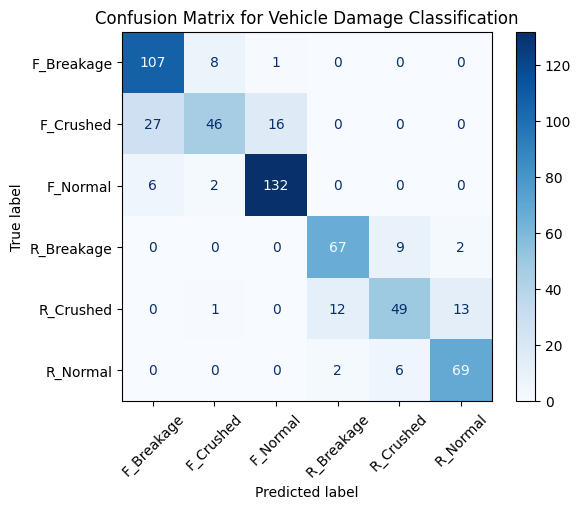

In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [54]:
torch.save(model.state_dict(), 'susnatacnn_model.pth')

In [55]:
from google.colab import files
files.download('susnatacnn_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
from google.colab import files
uploaded = files.upload()

Saving damagetest.jpg to damagetest.jpg


In [ ]:
from torchvision import transforms

infer_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [59]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CarClassifierResNet(num_classes=6).to(device)   # same arch as training
model.load_state_dict(torch.load("susnatacnn_model.pth", map_location=device))
model.eval()

CarClassifierResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


Prediction: F_Breakage
Top-3:
  F_Breakage: 99.92%
  R_Breakage: 0.08%
  F_Crushed: 0.00%


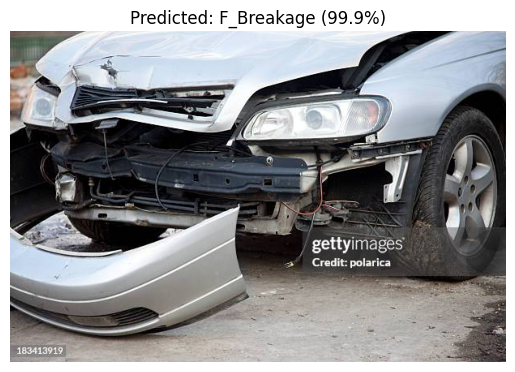

In [60]:
from PIL import Image
from torch.nn.functional import softmax
import matplotlib.pyplot as plt

class_names = ["F_Breakage","F_Crushed","F_Normal",
               "R_Breakage","R_Crushed","R_Normal"]

img_path = "damagetest.jpg"   # you uploaded it to Colab
img = Image.open(img_path).convert("RGB")

x = infer_tfms(img).unsqueeze(0).to(device)  # add batch dim
with torch.no_grad():
    logits = model(x)
    probs = softmax(logits, dim=1)[0]
    pred_idx = int(torch.argmax(probs))

print(f"Prediction: {class_names[pred_idx]}")
top3 = torch.topk(probs, 3)
print("Top-3:")
for i, p in zip(top3.indices.tolist(), top3.values.tolist()):
    print(f"  {class_names[i]}: {p*100:.2f}%")

# (optional) show image with title
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {class_names[pred_idx]} ({probs[pred_idx]*100:.1f}%)")
plt.show()